# Example for an excited state calculation

Short example of how to form the objectives for the ''hangman's'' approach to excited states.  
Here the states are sequentially computed and are kept orhogonal towards previous states by projection.  

The method was for example applied in:
https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.8b01004

The overlap objective is formed from the quantum circuits of the optimized lower lying states $U_i$ and the current parametrized circuit $U(a)$ like this:

$$
S_i^2(a) = \|\langle \Psi_i \rvert \Psi(a) \rangle\|^2 = \|\langle 0 \rvert U_i^\dagger U(a) \lvert 0 \rangle\|^2 = 
 \langle 0 \rvert U^\dagger(a) U_i  P_0 U_i^\dagger U(a) \lvert\rangle = \langle P_0 \rangle_{U_i^\dagger U(a)} $$
 
where $P0 = \lvert 0..0 \rangle \langle 0..0 \rvert = \frac{1}{2^n} \otimes_n (1 + Z(n))$.

Bound states can then be kept orthogonal by projecting lower lying states out which is equivalent as minimizing the objective:

$$
 L = \langle H \rangle_{U(a)} - E_i S_i^2(a)
$$


We will use an active space Beryllium Hydride molecule with two orbitals because the circuit template is easy to construct for this example and it executes fast.

<img src="data/ex_solver_cartoon-1.png" width="200" height="200" />

In [1]:
geomstring="be 0.0 0.0 0.0\nh 0.0 0.0 {R}\nh 0.0 0.0 -{R}"

In [4]:
import tequila as tq

fci_gs = []
fci_es = []
energies_gs = []
energies_es = []
P0 = tq.paulis.Projector("|00>")
for R in [0.7 + 0.1*i for i in range(25)]:
    print("Optimizing point R={:2.1f}".format(R))
    active = {"b1u": [0], "b2u": [0]}
    mol = tq.chemistry.Molecule(geometry=geomstring.format(R=R), basis_set="6-31g", active_orbitals=active)
    H = mol.make_hamiltonian()
    results = []
    for i in range(2):
        U = tq.gates.Ry((i, "a"), 0)
        U += tq.gates.CNOT(0, 1) + tq.gates.CNOT(0, 2)
        U += tq.gates.CNOT(1, 3) + tq.gates.X([2, 3])
        E = tq.ExpectationValue(U, H)
        active_vars = E.extract_variables()
        angles = {angle: 0.0 for angle in active_vars}
        for data, U2 in results:
            S2 = tq.ExpectationValue(H=P0, U=U2.dagger() + U)
            E -= data.energy * S2
            angles = {**angles, **data.angles}
        print("Starting to optimize state ", i)
        result = tq.optimizer_scipy.minimize(E, method="bfgs", variables=active_vars, initial_values=angles, silent=True)
        print("finished with energy {:2.8f}".format(result.energy))
        results.append((result, U))
    energies_gs.append(results[0][0].energy)
    energies_es.append(results[1][0].energy)

Optimizing point R=0.7
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Starting to optimize state  0
finished with energy -15.08170491
Starting to optimize state  1
finished with energy -14.15900421
Optimizing point R=0.8
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Starting to optimize state  0
finished with energy -15.36599843
Starting to optimize state  1
finished with energy -14.48743629
Optimizing point R=0.9
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Starting to optimize state  0
finished with energy -15.54369428
Starting to optimize state  1
finished with energy -14.70864582
Optimizing point R=1.0
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Starting to optimize state  0
finished with energy -15.65189560
Starting to 

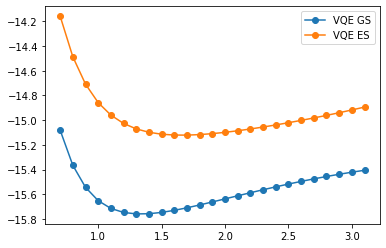

In [5]:
import matplotlib.pyplot as plt
R =  [0.7 + 0.1*i for i in range(len(energies_gs))]
plt.figure()
plt.plot(R, energies_gs, marker="o", label="VQE GS")
plt.plot(R, energies_es, marker="o", label="VQE ES")
plt.legend()
plt.show()

In [21]:
import tequila as tq
import numpy

fci_gs = []
fci_es = []
energies_gs = []
energies_es = []
P0 = tq.paulis.Projector("|00>")
for R in [0.7 + 0.1*i for i in range(25)]:
    print("Optimizing point R={:2.1f}".format(R))
    active = {"b1u": [0], "b2u": [0]}
    mol = tq.chemistry.Molecule(geometry=geomstring.format(R=R), basis_set="6-31g", active_orbitals=active)
    H = mol.make_hamiltonian()
    results = []
    for i in range(2):
        U = mol.make_upccgsd_ansatz(label=i, include_singles=False) # we need to label, otherwise tequila can not distinguish the variables from the different states
        E = tq.ExpectationValue(U, H)
        active_vars = E.extract_variables()
        angles = {angle: numpy.random.uniform(-0.01, 0.01, 1) for angle in active_vars}
        for data, U2 in results:
            S2 = tq.ExpectationValue(H=P0, U=U2.dagger() + U)
            E -= data.energy * S2
            print(data.angles)
            angles = {**angles, **data.angles}
        # we're switching to numerical gradients for faster execution
        print("Starting to optimize state ", i)
        result = tq.optimizer_scipy.minimize(E, silent=False, method="cobyla", gradient='2-point', method_options={"finite_diff_rel_step":1.e-4, "eps":1.e-4}, variables=active_vars, initial_values=angles)
        print("finished with energy {:2.8f}".format(result.energy))
        results.append((result, U))
    energies_gs.append(results[0][0].energy)
    energies_es.append(results[1][0].energy)

Optimizing point R=0.7
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Starting to optimize state  0
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 1 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=-15.08162587  angles= {((0, 1), (0, ((0, 2), (1, 3)))): 0.0057079581067258685}  samples= None
E=-14.87676911  angles= {((0, 1), (0, ((0, 2), (1, 3)))): 1.0057079581067259}  samples= None
E=-14.86239197  angles= {((0, 1), (0, ((0, 2), (1, 3)))): -0.9942920418932741}  samples= None
E=-15.02106255  angles= {((0, 1), (0, ((0, 2), (1, 3)))): -0.49429204189327414}  samples= None
E=-15.06939960  angles= {((0, 1), (0, ((0, 2), (1, 3)))): 0.25570795810672

E=+0.00000572  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.020098145423765854, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.0274478])}  samples= None
E=+0.00000191  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.022051270423765854, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.0274478])}  samples= None
E=-0.00000095  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.025004395423765854, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.0274478])}  samples= None
finished with energy -0.00000095
Optimizing point R=0.9
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Starting to optimize state  0
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 1 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None



E=+0.00015545  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.056812135439815774, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02981664])}  samples= None
E=+0.00069618  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.08806213543981578, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02981664])}  samples= None
E=+0.00002956  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.041187135439815774, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02981664])}  samples= None
E=+0.00000191  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.025562135439815774, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02981664])}  samples= None
E=+0.00006962  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.009937135439815774, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02981664])}  samples= None
E=+0.00002384  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.017749635439815774, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02981664])}  samples= None
E=+0.00000000  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.029468385439815774, ((0, 1), (0, ((0, 2), (1, 3)))): a

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00022602  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.003903482622607155, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03052957])}  samples= None
E=+0.15491390  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.9960965173773928, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03052957])}  samples= None
E=+0.17636967  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -1.0039034826226072, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03052957])}  samples= None
E=+0.05038834  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.5039034826226072, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03052957])}  samples= None
E=+0.00825787  angles= {((1,

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00026226  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.006710261599328393, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.0345712])}  samples= None
E=+0.14055729  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.9932897384006716, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.0345712])}  samples= None
E=+0.16271496  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -1.0067102615993284, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.0345712])}  samples= None
E=+0.04688549  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.5067102615993284, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.0345712])}  samples= None
E=+0.00724220  angles= {((1, 1),

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00028038  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.00897473071332458, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03528309])}  samples= None
E=+0.12919331  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.9910252692866754, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03528309])}  samples= None
E=+0.15119267  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -1.0089747307133246, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03528309])}  samples= None
E=+0.04380608  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.5089747307133246, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03528309])}  samples= None
E=+0.00650787  angles= {((1, 

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00022697  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.006357830442759005, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03170852])}  samples= None
E=+0.12143612  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.993642169557241, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03170852])}  samples= None
E=+0.14057064  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -1.006357830442759, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03170852])}  samples= None
E=+0.04050350  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.506357830442759, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03170852])}  samples= None
E=+0.00625801  angles= {((1, 1)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00017357  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.003835061170401919, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03257596])}  samples= None
E=+0.11573029  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.9961649388295981, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03257596])}  samples= None
E=+0.13203716  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -1.0038350611704019, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03257596])}  samples= None
E=+0.03776360  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.5038350611704019, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.03257596])}  samples= None
E=+0.00614262  angles= {((1,

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00011826  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.0005516940755385877, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02926126])}  samples= None
E=+0.11206818  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.9994483059244614, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02926126])}  samples= None
E=+0.12522984  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -1.0005516940755386, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02926126])}  samples= None
E=+0.03543282  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.5005516940755386, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02926126])}  samples= None
E=+0.00619984  angles= {((1

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00007153  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.0027155278631851368, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02582046])}  samples= None
E=+0.11014843  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 1.0027155278631852, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02582046])}  samples= None
E=+0.12024689  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.9972844721368148, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02582046])}  samples= None
E=+0.03360653  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.49728447213681487, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02582046])}  samples= None
E=+0.00637245  angles= {((1

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00009918  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.005283105554466978, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02259091])}  samples= None
E=+0.10765457  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.994716894445533, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02259091])}  samples= None
E=+0.11945534  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -1.0052831055544669, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02259091])}  samples= None
E=+0.03367424  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.505283105554467, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02259091])}  samples= None
E=+0.00603676  angles= {((1, 1

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00003338  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.0026875459479564386, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02040599])}  samples= None
E=+0.11022663  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 1.0026875459479565, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02040599])}  samples= None
E=+0.11715794  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.9973124540520435, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02040599])}  samples= None
E=+0.03227520  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.4973124540520435, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.02040599])}  samples= None
E=+0.00670147  angles= {((1,

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 1

E=+0.00003910  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.002157225545400921, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.01688646])}  samples= None
E=+0.11203957  angles= {((1, 1), (0, ((0, 2), (1, 3)))): 0.9978427744545991, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.01688646])}  samples= None
E=+0.11953640  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -1.002157225545401, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.01688646])}  samples= None
E=+0.03299904  angles= {((1, 1), (0, ((0, 2), (1, 3)))): -0.5021572255454009, ((0, 1), (0, ((0, 2), (1, 3)))): array([0.01688646])}  samples= None
E=+0.00676537  angles= {((1, 

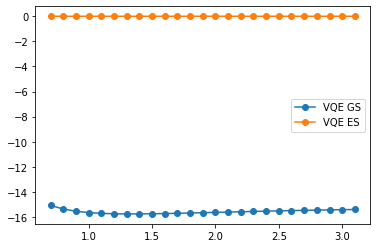

In [7]:
import matplotlib.pyplot as plt
R =  [0.7 + 0.1*i for i in range(len(energies_gs))]
plt.figure()
plt.plot(R, energies_gs, marker="o", label="VQE GS")
plt.plot(R, energies_es, marker="o", label="VQE ES")
plt.legend()
plt.show()

In [12]:
tq.show_available_optimizers()

available methods for optimizer modules found on your system:
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
lbfgs                | gpyopt
direct               | gpyopt
cma                  | gpyopt
phoenics             | phoenics
Supported optimizer modules:  ['scipy', 'phoenics', 'gpyopt', 'gd']
Installed optimizer modules:  ['scipy', '